# DNA Model Collapse Pipeline - Part 1: Generation

Generate sequences using DNABERT-2 and Nucleotide Transformer models.

**Workflow:**
1. Load both models (DNABERT-2 & NT-50m)
2. For each gene: Run 20 iterations of mask-generate cycles
3. Save results in `results/{model_name}/{gene_id}.csv`

## Step 1: 환경 설정 및 의존성 설치

In [1]:
# 필수 패키지 설치
!pip install -q transformers einops huggingface_hub matplotlib scikit-learn biopython torch

In [2]:
# 모듈 임포트
import sys
from pathlib import Path

# 현재 디렉토리를 경로에 추가 (모듈 로드용)
current_dir = Path('.').resolve()
if str(current_dir) not in sys.path:
    sys.path.insert(0, str(current_dir))

# 모듈 임포트
from preparation import get_device, load_models
from sequence_generation import (
    fetch_gene_sequences, sort_genes_by_length, 
    generate_and_embed_sequences, save_sequences_compressed,
    DEFAULT_DECODING_STRATEGIES
)
from visualization import (
    ResultsLoader, plot_semantic_similarity_overview,
    plot_gene_pair_comparison
)

print("✅ 모든 모듈 임포트 완료")

✅ 모든 모듈 임포트 완료


## Step 2: 디바이스 초기화 및 모델 로드

In [3]:
# 디바이스 감지 (CUDA / MPS / CPU)
device = get_device()
print(f"\n사용 중인 디바이스: {device}")

PyTorch Version: 2.9.1
Using device: mps

사용 중인 디바이스: mps


In [4]:
# 모델 로드
# DNABERT-2와 Nucleotide Transformer를 로드합니다
# 첫 실행 시 모델 다운로드에 시간이 걸릴 수 있습니다

models = load_models(device)
print(f"\n로드된 모델: {list(models.keys())}")

📥 Downloading DNABERT-2...


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

✅ DNABERT-2 Triton patch applied successfully.
[DNABERT-2] Loading model...


/Users/leeminjae/.cache/huggingface/modules/transformers_modules/_7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


[DNABERT-2] Model loaded successfully.
✅ DNABERT-2 loaded successfully.
[NT-v2-500m] Loading model...
[NT-v2-500m] Model loaded successfully.
✅ NT-v2-500m loaded successfully.

🚀 2 model(s) ready!

로드된 모델: ['DNABERT-2', 'NT-v2-500m']


## Step 3: NCBI에서 유전자 시퀀스 수집

In [5]:
# NCBI Entrez에 사용할 이메일 주소
# 실제 이메일로 변경하세요
NCBI_EMAIL = "your_email@example.com"

# 유전자 시퀀스 수집
gene_selection = fetch_gene_sequences(NCBI_EMAIL)

# 시퀀스 길이 기준으로 정렬 (오름차순)
gene_selection = sort_genes_by_length(gene_selection)

print("\n수집된 유전자:")
for gene, seq in gene_selection.items():
    print(f"  - {gene}: {len(seq)} bp (앞 50bp: {seq[:50]}...)")

Fetching gene sequences from NCBI...
Fetching GAPDH by UID NM_002046.7...
  ✅ Found and added sequence for GAPDH (Length: 1285bp)
Fetching STAT3 by UID NM_139276.3...
  ✅ Found and added sequence for STAT3 (Length: 4921bp)
Fetching GAPDHP1 by UID NG_001123.6...
  ✅ Found and added sequence for GAPDHP1 (Length: 1098bp)
Searching for H4C1...
  ✅ Found and added sequence for H4C1 (Length: 396bp)
Searching for TP53...
  ✅ Found and added sequence for TP53 (Length: 1182bp)
Searching for NORAD...
  ✅ Found and added sequence for NORAD (Length: 5378bp)

✅ Gene fetching complete!
Genes successfully loaded: ['GAPDH', 'STAT3', 'GAPDHP1', 'H4C1', 'TP53', 'NORAD']

수집된 유전자:
  - H4C1: 396 bp (앞 50bp: AGAAGCTGTCTATCGGGCTCCAGCGGTCATGTCCGGCAGAGGAAAGGGCG...)
  - GAPDHP1: 1098 bp (앞 50bp: ATGGAAATCCCATCACCATCTTCCAGGAGCGAGATCCCTCCAAAATCAAG...)
  - TP53: 1182 bp (앞 50bp: ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTCAGGA...)
  - GAPDH: 1285 bp (앞 50bp: GCTCTCTGCTCCTCCTGTTCGACAGTCAGCCGCATCTTCTTTTGCGTCGC...

## Step 4: 시퀀스 생성 및 임베딩 추출

⚠️ **주의**: 이 단계는 시간이 오래 걸릴 수 있습니다.
- 전체 처리: 모든 유전자 × 모든 모델 × 모든 전략
- 각 시퀀스당 50번의 진화 스텝

### 설정 옵션
- `iterations`: 진화 스텝 수 (기본값: 50)
- `mask_ratio`: 각 스텝에서 마스킹할 뉴클레오타이드 비율 (기본값: 0.15)
- `store_in_memory`: 메모리에 전체 데이터 보관 여부 (기본값: False)
- `save_each_strategy`: 전략별로 개별 파일 저장 (기본값: True)

In [6]:
# 실행 파라미터
ITERATIONS = 50  # 진화 스텝 수
MASK_RATIO = 0.15  # 마스킹 비율
OUTPUT_DIR = Path('output')  # 출력 디렉토리
STORE_IN_MEMORY = False  # 메모리에 전체 보관 여부
USE_NOTEBOOK_TQDM = True  # Jupyter 노트북에서 진행률 표시줄 사용

print(f"설정:")
print(f"  - 반복 횟수: {ITERATIONS}")
print(f"  - 마스킹 비율: {MASK_RATIO}")
print(f"  - 출력 디렉토리: {OUTPUT_DIR}")
print(f"  - 메모리 저장: {STORE_IN_MEMORY}")
print(f"  - 노트북 진행률 표시: {USE_NOTEBOOK_TQDM}")

설정:
  - 반복 횟수: 50
  - 마스킹 비율: 0.15
  - 출력 디렉토리: output
  - 메모리 저장: False
  - 노트북 진행률 표시: True


In [7]:
# 시퀀스 생성 및 임베딩 추출
all_generated_sequences, all_gene_embeddings = generate_and_embed_sequences(
    gene_selection=gene_selection,
    models=models,
    decoding_strategies=DEFAULT_DECODING_STRATEGIES,
    iterations=ITERATIONS,
    mask_ratio=MASK_RATIO,
    save_all_sequences=True,
    save_interval=5,
    output_dir=OUTPUT_DIR,
    store_in_memory=STORE_IN_MEMORY,
    save_each_strategy=True,
    device=device,
    use_notebook_tqdm=USE_NOTEBOOK_TQDM
)

print("✅ 시퀀스 생성 및 임베딩 추출 완료!")

Processing Genes:   0%|          | 0/6 [00:00<?, ?it/s]

  Model for H4C1:   0%|          | 0/2 [00:00<?, ?it/s]

  Model for GAPDHP1:   0%|          | 0/2 [00:00<?, ?it/s]

  Model for TP53:   0%|          | 0/2 [00:00<?, ?it/s]

  Model for GAPDH:   0%|          | 0/2 [00:00<?, ?it/s]

  Model for STAT3:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/leeminjae/.cache/huggingface/modules/transformers_modules/_7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py:433: UserWarning: Increasing alibi size from 512 to 983
  warnings.warn(
/Users/leeminjae/.cache/huggingface/modules/transformers_modules/_7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py:433: UserWarning: Increasing alibi size from 983 to 987
  warnings.warn(
/Users/leeminjae/.cache/huggingface/modules/transformers_modules/_7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py:433: UserWarning: Increasing alibi size from 987 to 989
  warnings.warn(
/Users/leeminjae/.cache/huggingface/modules/transformers_modules/_7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py:433: UserWarning: Increasing alibi size from 989 to 990
  warnings.warn(
/Users/leeminjae/.cache/huggingface/modules/transformers_modules/_7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py:433: UserWarning: Increasing alibi size from 990 to 993
  warnings.warn(
/Users/leeminjae/.cache/h

  Model for NORAD:   0%|          | 0/2 [00:00<?, ?it/s]


✅ All sequence generation and embedding complete!
✅ 시퀀스 생성 및 임베딩 추출 완료!


## Step 5: 결과 시각화 (선택 사항)

저장된 데이터 또는 메모리의 데이터를 시각화합니다.

### 시각화 유형
1. **Semantic Similarity Overview**: 모든 유전자의 의미적 유사도 추이 (2x2 그리드)
2. **Gene Pair Comparison**: 두 유전자의 상세 비교 (유사도 + 엔트로피 + 길이)

In [8]:
# 저장된 데이터 로드 (메모리에 없는 경우)
# 아래 코드는 이미 메모리에 있는 데이터를 사용하거나
# 저장된 파일에서 다시 로드할 때 사용합니다

loader = ResultsLoader(output_dir=OUTPUT_DIR)

# 메모리에 데이터가 없으면 디스크에서 로드
if not all_gene_embeddings or not STORE_IN_MEMORY:
    print("디스크에서 임베딩 데이터를 로드 중...")
    all_gene_embeddings = loader.load_embeddings()

if not all_generated_sequences or not STORE_IN_MEMORY:
    print("디스크에서 시퀀스 데이터를 로드 중...")
    all_generated_sequences = loader.load_sequences()

print("✅ 데이터 로드 완료")

디스크에서 임베딩 데이터를 로드 중...
Loading embeddings from parts directory...
✅ Loaded embeddings for genes: ['H4C1', 'GAPDHP1', 'TP53', 'STAT3', 'GAPDH', 'NORAD']
디스크에서 시퀀스 데이터를 로드 중...
Loading sequences from parts directory...
✅ Loaded sequences for genes: ['H4C1', 'GAPDHP1', 'TP53', 'STAT3', 'GAPDH', 'NORAD']
✅ 데이터 로드 완료


### 시각화 1: DNABERT-2 의미적 유사도 개요

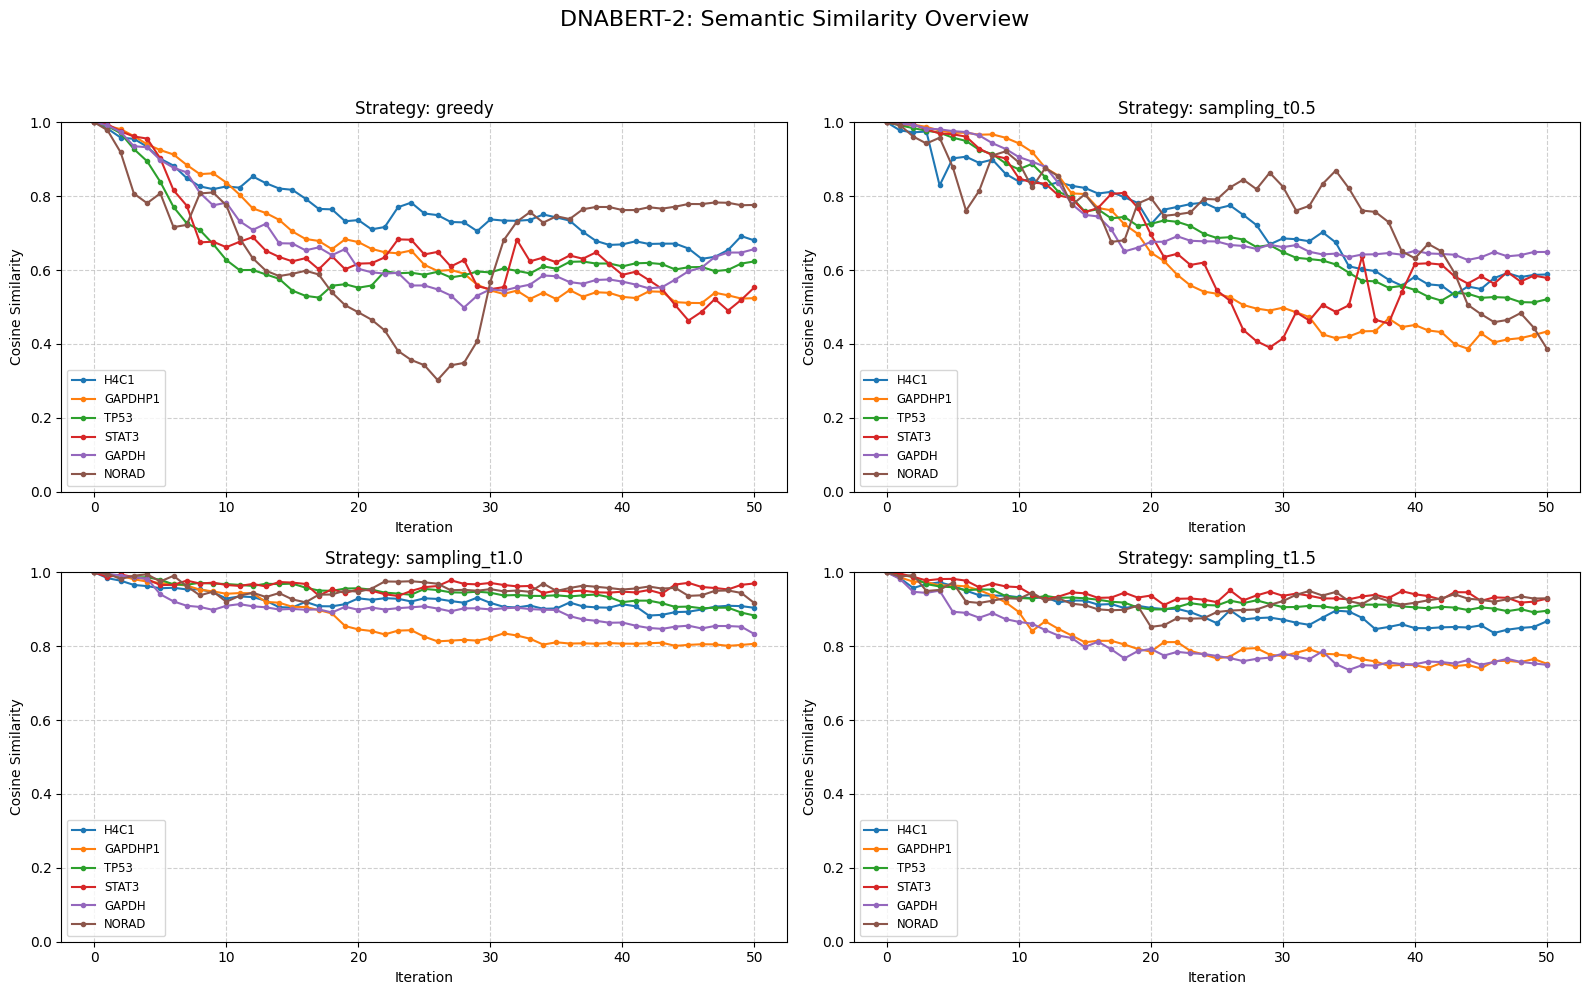

✅ DNABERT-2 overview plot generated.


In [9]:
# DNABERT-2 모델의 모든 유전자 및 전략에 대한 의미적 유사도 시각화
if all_gene_embeddings:
    plot_semantic_similarity_overview(
        all_gene_embeddings,
        model_label="DNABERT-2"
    )
else:
    print("⚠️ 임베딩 데이터가 없습니다.")

### 시각화 2: 유전자 쌍 비교 (Coding vs Non-coding)

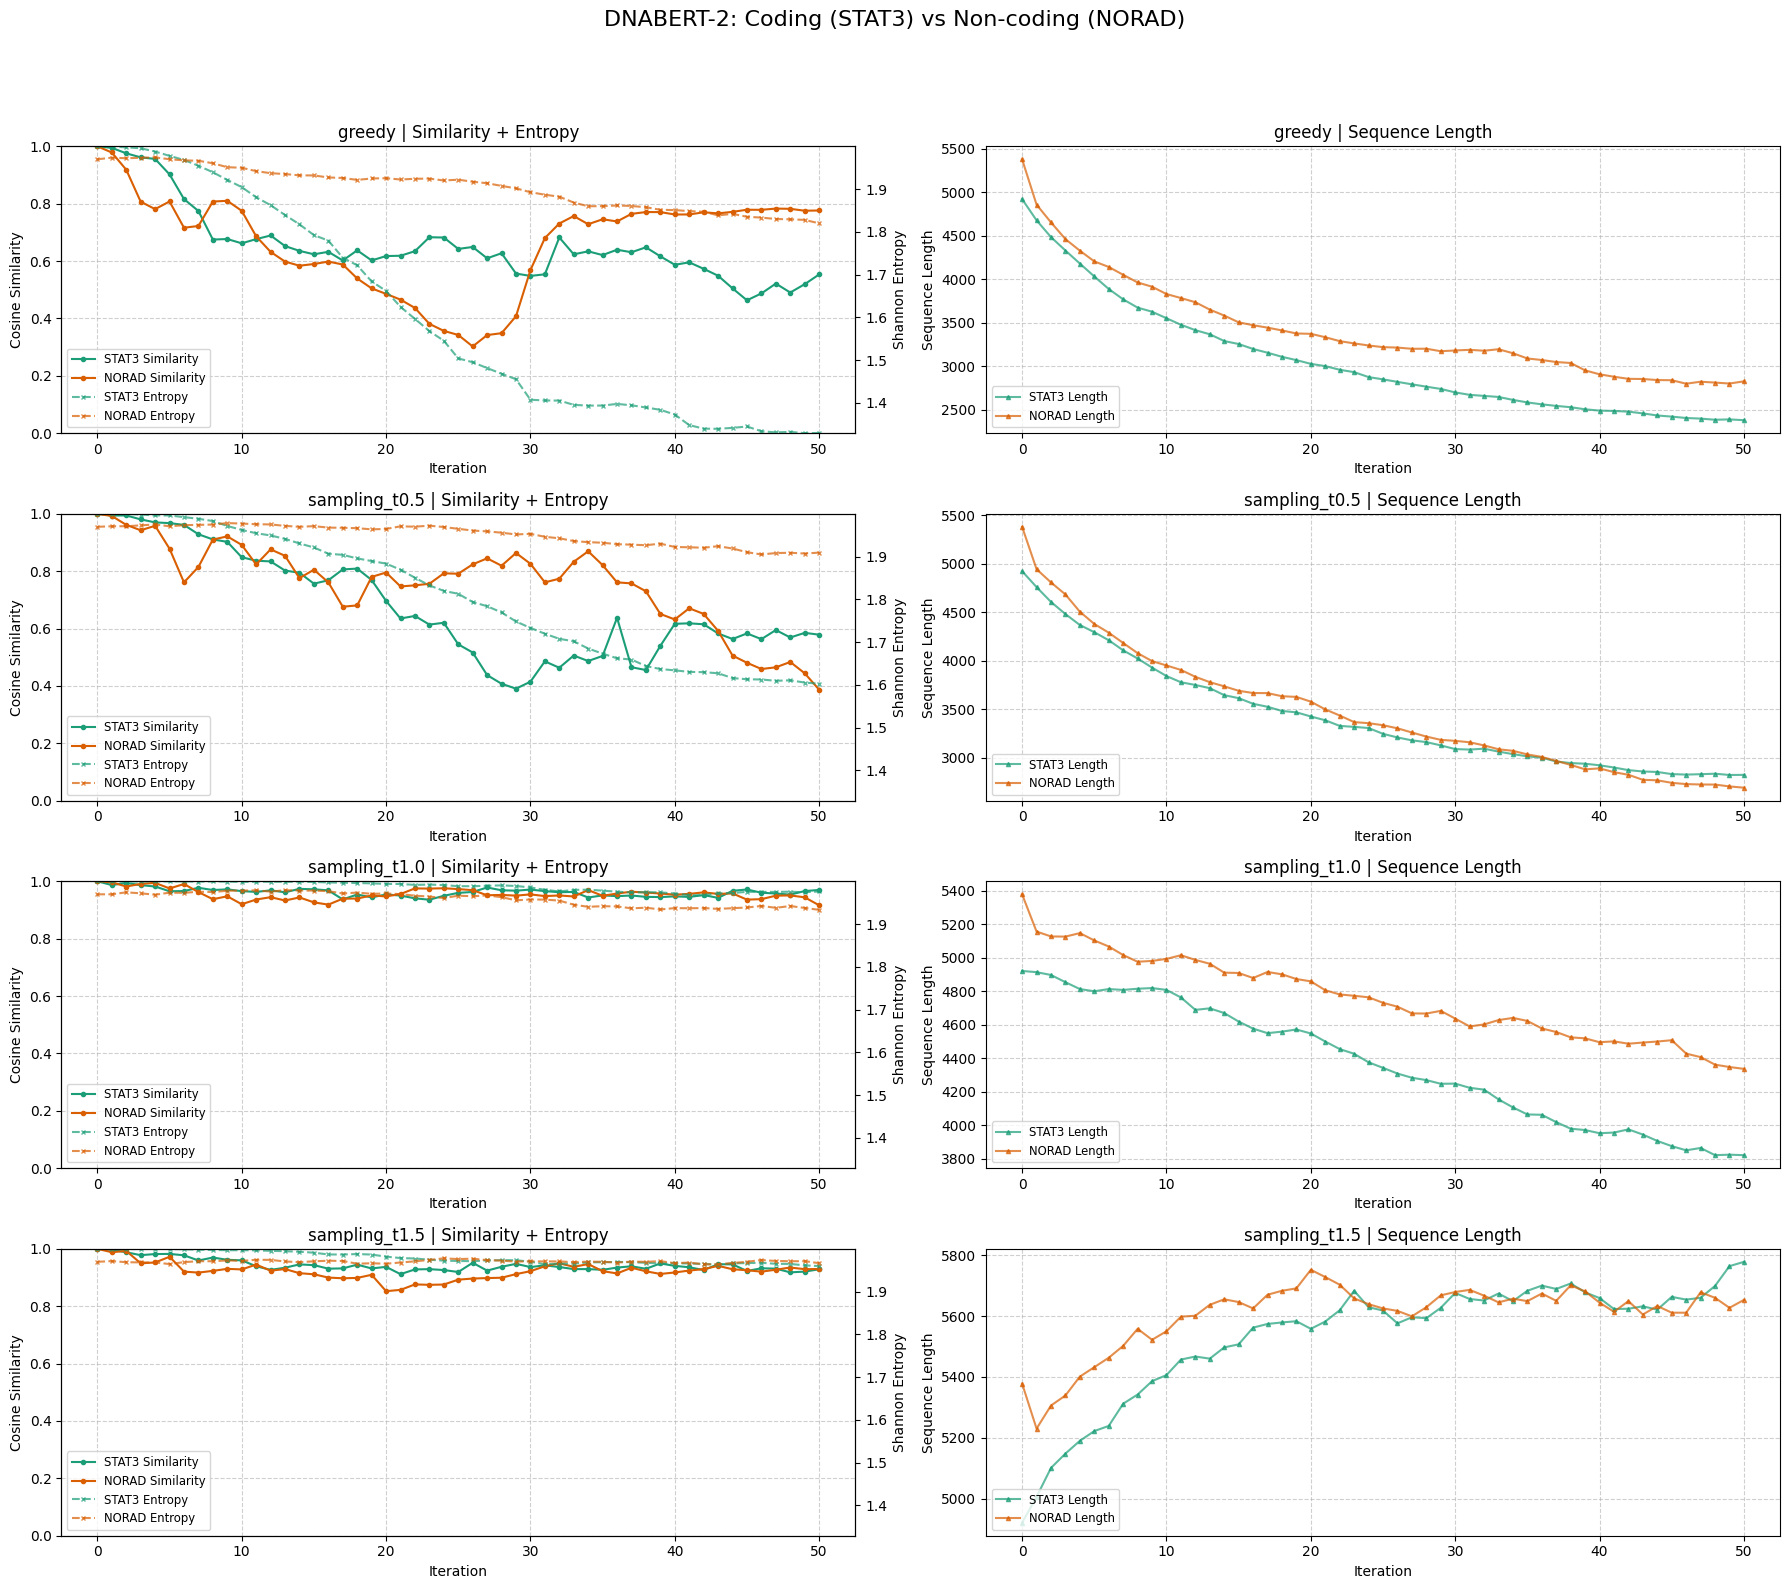

✅ Gene pair comparison plot generated.


In [10]:
# STAT3 (단백질 코딩) vs NORAD (비-코딩) 비교
if all_gene_embeddings and all_generated_sequences:
    if 'STAT3' in all_gene_embeddings and 'NORAD' in all_gene_embeddings:
        plot_gene_pair_comparison(
            all_gene_embeddings,
            all_generated_sequences,
            gene_a='STAT3',
            gene_b='NORAD',
            title='DNABERT-2: Coding (STAT3) vs Non-coding (NORAD)',
            model_label='DNABERT-2'
        )
    else:
        print("⚠️ STAT3 또는 NORAD 데이터가 없습니다.")
else:
    print("⚠️ 필요한 데이터가 없습니다.")

### 시각화 3: 유전자 쌍 비교 (Real vs Pseudo)

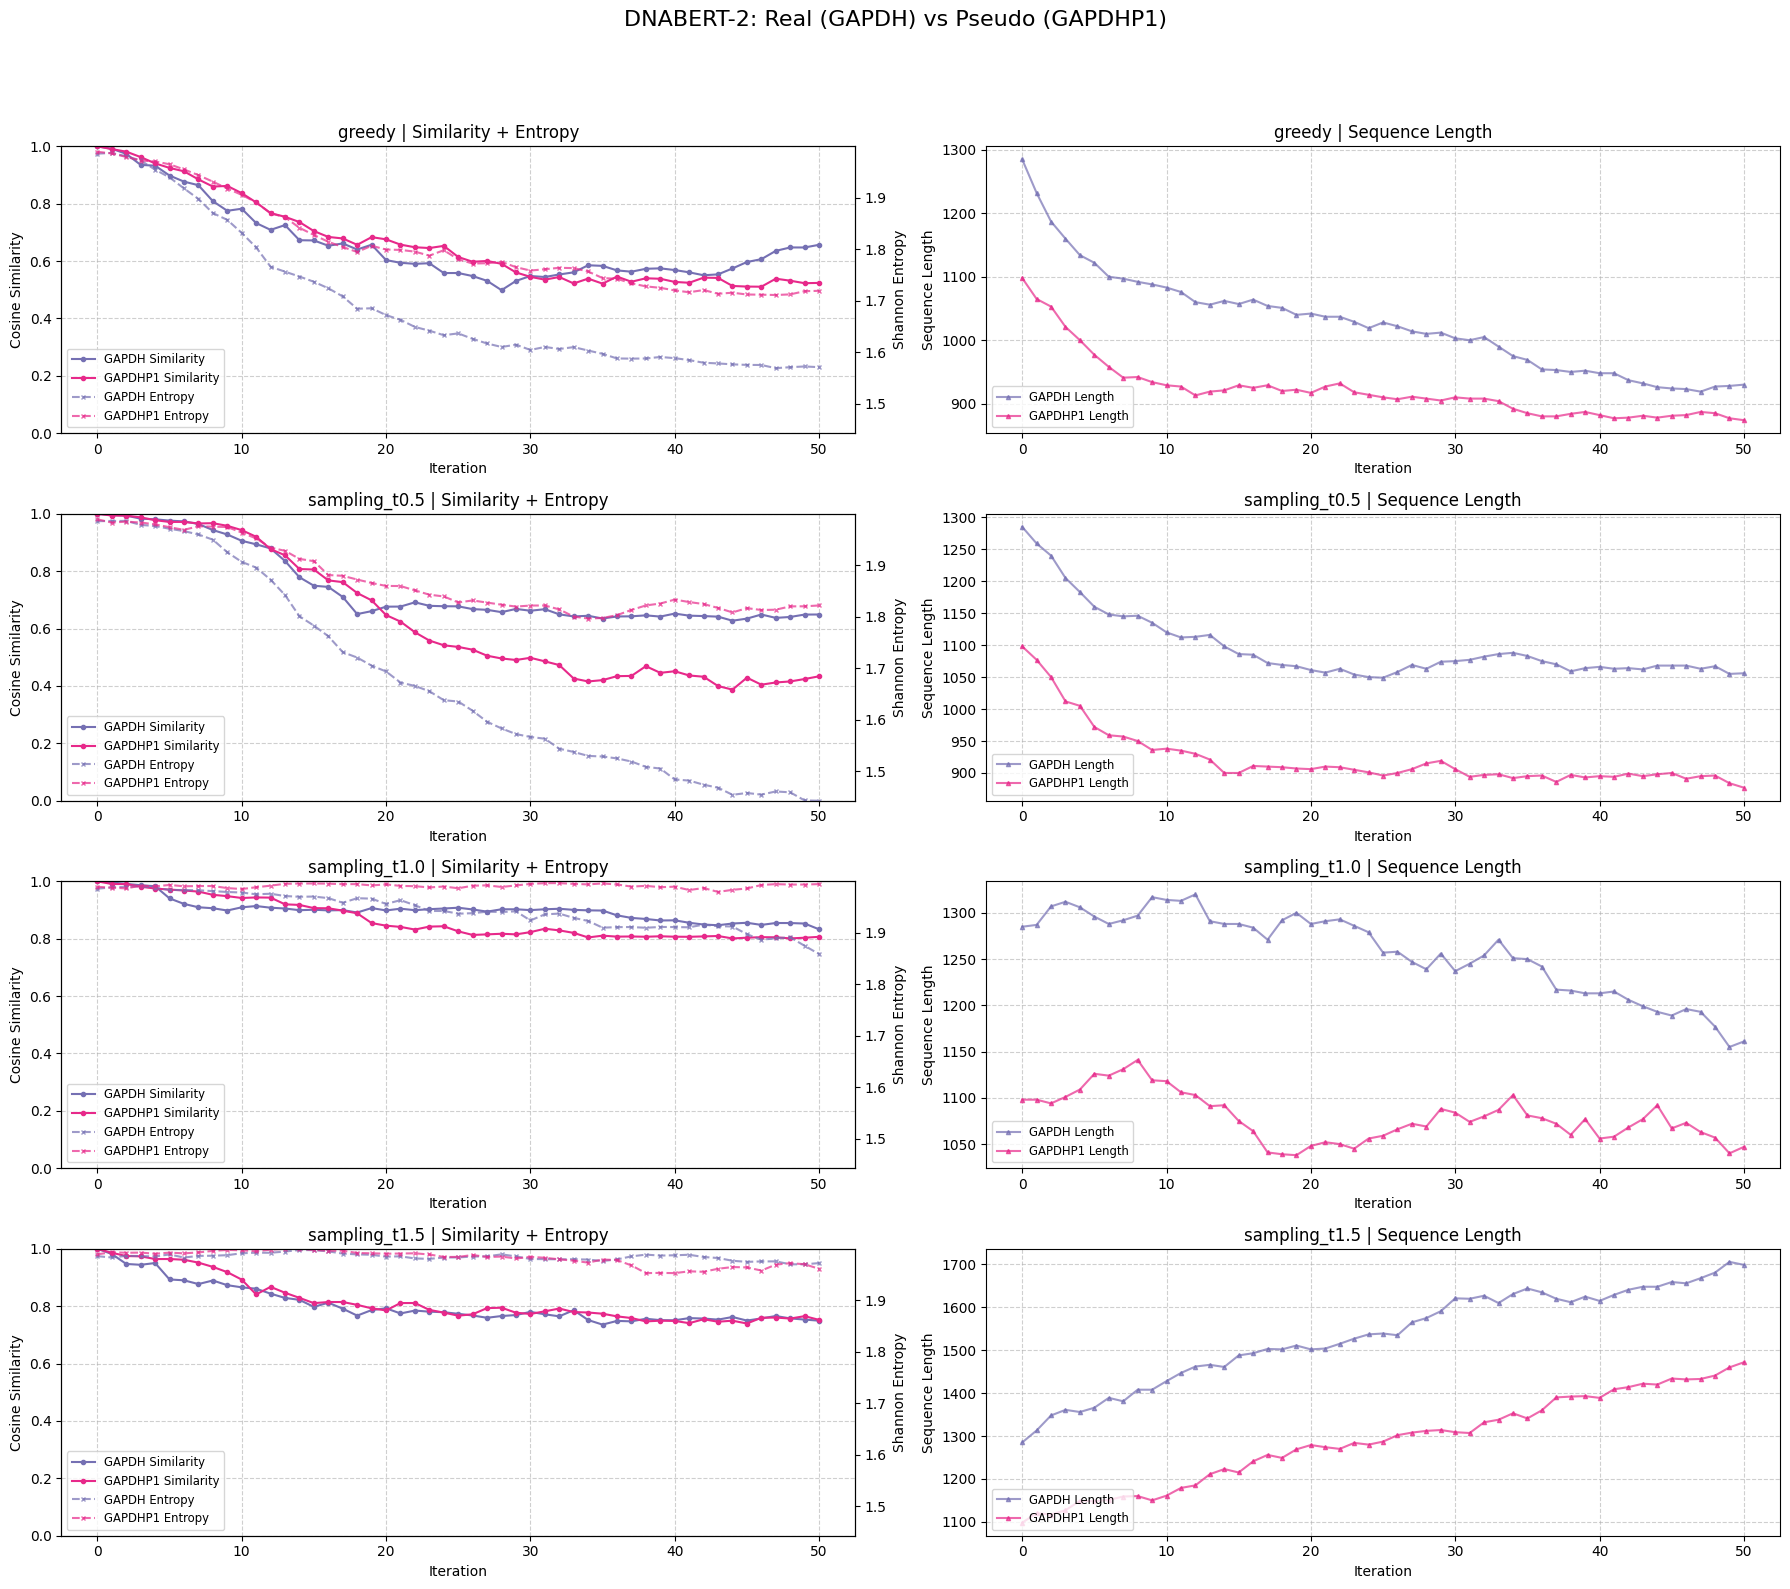

✅ Gene pair comparison plot generated.


In [11]:
# GAPDH (실제 유전자) vs GAPDHP1 (의사 유전자) 비교
if all_gene_embeddings and all_generated_sequences:
    if 'GAPDH' in all_gene_embeddings and 'GAPDHP1' in all_gene_embeddings:
        plot_gene_pair_comparison(
            all_gene_embeddings,
            all_generated_sequences,
            gene_a='GAPDH',
            gene_b='GAPDHP1',
            title='DNABERT-2: Real (GAPDH) vs Pseudo (GAPDHP1)',
            model_label='DNABERT-2'
        )
    else:
        print("⚠️ GAPDH 또는 GAPDHP1 데이터가 없습니다.")
else:
    print("⚠️ 필요한 데이터가 없습니다.")

## 추가 분석 및 커스터마이제이션

### 다른 유전자 쌍 비교
아래 셀을 수정하여 다른 유전자 쌍을 비교할 수 있습니다.

In [12]:
# 사용 가능한 유전자 확인
available_genes = list(all_gene_embeddings.keys()) if all_gene_embeddings else []
print(f"사용 가능한 유전자: {available_genes}")

# 커스텀 유전자 쌍 비교 예제
if len(available_genes) >= 2:
    gene_a = available_genes[0]
    gene_b = available_genes[1]
    print(f"\n{gene_a} vs {gene_b} 비교")
    # plot_gene_pair_comparison(
    #     all_gene_embeddings,
    #     all_generated_sequences,
    #     gene_a=gene_a,
    #     gene_b=gene_b,
    #     title=f'DNABERT-2: {gene_a} vs {gene_b}',
    #     model_label='DNABERT-2'
    # )
else:
    print("비교할 충분한 유전자가 없습니다.")

사용 가능한 유전자: ['H4C1', 'GAPDHP1', 'TP53', 'STAT3', 'GAPDH', 'NORAD']

H4C1 vs GAPDHP1 비교


## 데이터 저장 및 로드

생성된 시퀀스와 임베딩을 압축하여 저장하거나 로드합니다.

In [13]:
# 메모리에 있는 데이터를 압축하여 저장
if all_generated_sequences or all_gene_embeddings:
    print("💾 데이터 저장 중...")
    
    if all_generated_sequences:
        save_sequences_compressed(
            all_generated_sequences,
            OUTPUT_DIR / 'generated_sequences',
            compression='gzip'
        )
    
    if all_gene_embeddings:
        save_sequences_compressed(
            all_gene_embeddings,
            OUTPUT_DIR / 'gene_embeddings',
            compression='pickle_gzip'
        )
    
    print("✅ 데이터 저장 완료!")
else:
    print("저장할 데이터가 없습니다.")

💾 데이터 저장 중...
✅ Saved to output/generated_sequences.json.gz (compressed)
✅ Saved to output/gene_embeddings.pkl.gz (compressed)
✅ 데이터 저장 완료!


## 요약

이 가이드북을 통해 다음을 완료했습니다:

1. ✅ **환경 초기화**: CUDA/MPS/CPU 자동 감지, 필수 패키지 설치
2. ✅ **모델 로드**: DNABERT-2 및 Nucleotide Transformer 로드
3. ✅ **유전자 수집**: NCBI에서 6개 유전자 시퀀스 수집
4. ✅ **시퀀스 진화**: 반복적 진화를 통한 변형 시퀀스 생성
5. ✅ **임베딩 추출**: 각 시퀀스에 대한 의미적 표현 추출
6. ✅ **시각화**: 의미적 유사도 및 유전자 쌍 비교 시각화
7. ✅ **데이터 저장**: 압축된 형식으로 결과 저장

### 다음 단계
- 다른 디코딩 전략 시도 (temperature, top_k 조정)
- 더 많은 반복 횟수로 더 깊은 진화 분석
- Nucleotide Transformer 결과와 비교
- 결과를 논문이나 보고서에 포함

## Step 1: Setup Environment

In [14]:
import sys
import os
from pathlib import Path

# Configure environment
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Add src to path
src_path = Path.cwd() / 'src'
sys.path.insert(0, str(src_path))

# Initialize results directory
results_dir = Path.cwd() / 'results'
results_dir.mkdir(exist_ok=True)

print('✓ Environment configured')
print(f'  Working dir: {Path.cwd()}')
print(f'  Results dir: {results_dir}')

✓ Environment configured
  Working dir: /Users/leeminjae/Desktop/01_Projects/iterative reconstruction of DNA sequence/DNA_Model_Collapse
  Results dir: /Users/leeminjae/Desktop/01_Projects/iterative reconstruction of DNA sequence/DNA_Model_Collapse/results


## Step 2: Load Models

In [15]:
import warnings
warnings.filterwarnings('ignore')

import torch
from preparation import ModelLoader, GeneFetcher

# Configuration
MODELS = ['dnabert2', 'nt-50m']
GENES = ['TP53', 'GAPDH', 'H4C1', 'STAT3', 'NORAD', 'GAPDHP1']
ITERATIONS = 20

print('Loading models...')
models_dict = {}

for model_key in MODELS:
    try:
        print(f'  Loading {model_key}...')
        model_loader = ModelLoader(model_key=model_key)
        model_loader.load()
        models_dict[model_key] = {
            'model': model_loader.get_model(),
            'tokenizer': model_loader.get_tokenizer(),
            'device': model_loader.device
        }
        print(f'    ✓ {model_key} loaded (device: {models_dict[model_key]["device"]})')
    except Exception as e:
        print(f'    ✗ Error loading {model_key}: {e}')
        raise

print(f'\n✓ All {len(models_dict)} models loaded')

ImportError: cannot import name 'ModelLoader' from 'preparation' (/Users/leeminjae/Desktop/01_Projects/iterative reconstruction of DNA sequence/DNA_Model_Collapse/preparation.py)

## Step 3: Generate Sequences

In [ ]:
import gc
from sequence_generation import SequenceMasker, SequenceGenerator

# Load gene sequences
print('Loading gene sequences...')
gene_fetcher = GeneFetcher()
genes_dict = {}

for gene_id in GENES:
    try:
        seq = gene_fetcher.get_sequence(gene_id)
        genes_dict[gene_id] = seq
        print(f'  ✓ {gene_id}: {len(seq)} bp')
    except Exception as e:
        print(f'  ✗ Error loading {gene_id}: {e}')

print(f'\n✓ Loaded {len(genes_dict)} genes')

In [ ]:
# Generation pipeline
print(f'\nGenerating sequences ({ITERATIONS} iterations each)\n')
print('='*70)

for model_key in MODELS:
    print(f'\nModel: {model_key}')
    model_info = models_dict[model_key]
    model = model_info['model']
    tokenizer = model_info['tokenizer']
    device = model_info['device']
    
    # Initialize generator
    masker = SequenceMasker(strategy='random', ratio=0.15)
    generator = SequenceGenerator(model=model, tokenizer=tokenizer, device=device, masker=masker)
    
    for gene_id in GENES:
        print(f'  {gene_id}...', end='', flush=True)
        
        # Prepare output
        model_name = model_key.replace('/', '-')
        output_csv = results_dir / model_name / f'{gene_id}.csv'
        output_csv.parent.mkdir(parents=True, exist_ok=True)
        
        # Clear previous results if exists
        if output_csv.exists():
            output_csv.unlink()
        
        # Generate
        initial_sequence = genes_dict[gene_id]
        generator.generate_iteratively(
            initial_sequence=initial_sequence,
            iterations=ITERATIONS,
            strategy='greedy',
            temperature=1.0,
            output_csv=str(output_csv),
        )
        
        # Memory cleanup
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        print(f' ✓')

print('\n' + '='*70)
print('✓ Generation complete!')
print(f'Results saved to: {results_dir}')

## Step 4: Verify Results

In [ ]:
import pandas as pd

print('Verification of generated results:\n')
print('='*70)

for model_key in MODELS:
    model_name = model_key.replace('/', '-')
    model_dir = results_dir / model_name
    
    print(f'\n{model_key}:')
    
    for gene_id in GENES:
        csv_file = model_dir / f'{gene_id}.csv'
        if csv_file.exists():
            df = pd.read_csv(csv_file)
            print(f'  {gene_id:10s}: {len(df):2d} iterations, lengths: {df["sequence_length"].min()}-{df["sequence_length"].max()} bp')
        else:
            print(f'  {gene_id:10s}: ✗ FILE NOT FOUND')

print('\n' + '='*70)